In [1]:
import math
import os
from glob import glob
from itertools import combinations
from urllib.error import URLError

import earthpy as et
import earthpy.appeears as etapp
import geopandas as gpd
import holoviews as hv
import hvplot as hv
import hvplot.pandas
import hvplot.xarray
import numpy as np
import pandas as pd
import requests
import rioxarray as rxr
import rioxarray.merge as rxrmerge
import skfuzzy as fuzz
from skfuzzy import control as ctrl
from IPython.display import Image
import xarray as xr
import warnings
import zipfile


data_dir = os.path.join(et.io.HOME, et.io.DATA_NAME, 'treebeard')
wbd_url = (
    'https://prd-tnm.s3.amazonaws.com'
    '/StagedProducts/Hydrography/WBD/HU2/Shape'
    '/WBD_10_HU2_Shape.zip')
wdb_shp_file = os.path.join(data_dir, 'WBD_10_HU2_Shape', 'Shape', 'WBDHU10.shp')

drapp_url = (
    'https://gisdata.drcog.org:8443'
    '/geoserver/DRCOGPUB/ows?'
    'service=WFS&version=1.0.0&'
    'request=GetFeature&'
    'typeName=DRCOGPUB:drapp_tile_scheme_2020'
    '&outputFormat=SHAPE-ZIP'
)
drapp_shp_file = os.path.join(data_dir, 'drapp_tile_scheme_2020', 'drapp_tile_scheme_2020.shp')

# Create the directory if it doesn't exist
os.makedirs(data_dir, exist_ok=True)

# Download the files
download_and_extract = False
if download_and_extract:
    wdb_resp = requests.get(wbd_url)
    drapp_resp = requests.get(drapp_url)

In [2]:
def extract_zip(target_dir, zip_filename, resp):
    zip_path = os.path.join(data_dir, zip_filename)
    with open(zip_path, 'wb') as f:
        f.write(resp.content)
    with zipfile.ZipFile(zip_path, 'r') as z:
        z.extractall(target_dir)

In [3]:
wbd_dir = os.path.join(data_dir, 'WBD_10_HU2_Shape')
drapp_dir = os.path.join(data_dir, 'drapp_tile_scheme_2020')
if download_and_extract:
    extract_zip(wbd_dir, 'WBD_10_HU2_Shape.zip', wdb_resp)
    extract_zip(drapp_dir, 'drapp_tile_scheme_2020.zip', drapp_resp)

In [4]:
wdb_shp_file

'/Users/ed.chan/earth-analytics/data/treebeard/WBD_10_HU2_Shape/Shape/WBDHU10.shp'

In [5]:
drapp_shp_file

'/Users/ed.chan/earth-analytics/data/treebeard/drapp_tile_scheme_2020/drapp_tile_scheme_2020.shp'

In [6]:
wdb_gdf = gpd.read_file(wdb_shp_file)
left_hand_creek_gdf = wdb_gdf[wdb_gdf['huc10'] == '1019000503'].copy()
study_area_gdf = wdb_gdf[wdb_gdf['huc10'].astype(str).str.startswith('10190005')].copy()

In [7]:
plot = left_hand_creek_gdf.hvplot(geo=True, color='blue', tiles='OSM',
                                alpha=0.3)
plot

/Users/ed.chan/miniconda3/envs/treebeard/lib/python3.10/site-packages/dask/dataframe/__init__.py:31: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


:Overlay
   .WMTS.I     :WMTS   [Longitude,Latitude]
   .Polygons.I :Polygons   [Longitude,Latitude]

In [8]:
left_hand_creek_gdf

tnmid metasource sourcedata sourceorig  \
48  {E27AC9D0-4FAC-486F-A1AA-667A4B584596}       None       None       None   

   sourcefeat    loaddate referenceg  areaacres  areasqkm states       huc10  \
48       None  2012-10-24       None   46585.71    188.53     CO  1019000503   

               name hutype humod shape_Leng shape_Area  ObjectID  \
48  Left Hand Creek      S  None       None       None        49   

                                             geometry  
48  POLYGON ((-105.31911 40.17821, -105.31757 40.1...

In [9]:
drapp_gdf = gpd.read_file(drapp_shp_file)
drapp_gdf = drapp_gdf.to_crs(left_hand_creek_gdf.crs) # EPSG:6428 -> EPSG:4269
drapp_gdf

project area      resolution     tile photo_date       storage  \
0         2020   1a  3 Inch, 6 Inch  S3E194c   20200426  drapparchive   
1         2020   1a  3 Inch, 6 Inch  S3E194d   20200426  drapparchive   
2         2020   1a  3 Inch, 6 Inch  S3E195c   20200426  drapparchive   
3         2020   1a  3 Inch, 6 Inch  S3E195d   20200426  drapparchive   
4         2020   1a  3 Inch, 6 Inch  S3E196c   20200426  drapparchive   
...        ...  ...             ...      ...        ...           ...   
10130     2020    3         12 Inch   N4W379   20200711  drapparchive   
10131     2020    3         12 Inch   N4W348   20200711  drapparchive   
10132     2020    3         12 Inch   N4W349   20200711  drapparchive   
10133     2020    3         12 Inch   N4W338   20200711  drapparchive   
10134     2020    3         12 Inch   N4W339   20200711  drapparchive   

                                                geometry  
0      POLYGON ((-104.92568 39.30538, -104.92562 39.3...  
1      POLYGON ((-104.91635 39.30533, -104.91629 39.3...  
2      POLYGON ((-104.90702 39.30529, -104.90696 39.3...  
3      POLYGON ((-104.89769 39.30524, -104.89763 39.3...  
4      POLYGON ((-104.88836 39.30519, -104.88830 39.3...  
...                                                  ...  
10130  POLYGON ((-105.39078 40.20540, -105.39075 40.2...  
10131  POLYGON ((-105.40962 40.24889, -105.40960 40.2...  
10132  POLYGON ((-105.39071 40.24888, -105.39069 40.2...  
10133  POLYGON ((-105.40960 40.26338, -105.40958 40.2...  
10134  POLYGON ((-105.39069 40.26337, -105.39066 40.2...  

[10135 rows x 7 columns]

In [10]:
drapp_plot = drapp_gdf.hvplot(geo=True, color='red', tiles='OSM', alpha=0.3)
drapp_plot

:Overlay
   .WMTS.I     :WMTS   [Longitude,Latitude]
   .Polygons.I :Polygons   [Longitude,Latitude]

In [11]:
filtered_drapp_gdf = gpd.sjoin(drapp_gdf, left_hand_creek_gdf, how='inner', op='intersects')

/Users/ed.chan/miniconda3/envs/treebeard/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3517: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [12]:
filtered_drapp_plot = filtered_drapp_gdf.hvplot(geo=True, color='red', tiles='OSM', 
                    alpha=0.3, hover_cols=['tile'])
filtered_drapp_plot

:Overlay
   .WMTS.I     :WMTS   [Longitude,Latitude]
   .Polygons.I :Polygons   [Longitude,Latitude]   (tile)

In [13]:
len(filtered_drapp_gdf['tile'])

116

In [14]:
len(filtered_drapp_gdf['tile'].unique())

116

In [15]:
tile_base_url = 'https://drapparchive.s3.amazonaws.com/2020/'
tile_urls = [f'{tile_base_url}{tile}.tif' for tile in filtered_drapp_gdf['tile'].unique()]
# twf_urls = [f'{tile_base_url}{tile}.tfw' for tile in filtered_drapp_gdf['tile'].unique()]
test_urls = [url for url in tile_urls if 'N3W345.tif' in url]

In [16]:
test_urls

['https://drapparchive.s3.amazonaws.com/2020/N3W345.tif']

In [17]:
drapp_tiles_dir = os.path.join(data_dir, 'drapp_tiles')
os.makedirs(drapp_tiles_dir, exist_ok=True)

In [18]:
def download_files(urls):
    count = 0 
    for url in urls:
        print(f"Downloading {url}...")
        filename = os.path.basename(url)
        path = os.path.join(drapp_tiles_dir, filename)
        if not os.path.exists(path):
            resp = requests.get(url)
            with open(path, 'wb') as f:
                f.write(resp.content)
        count += 1
        if count == 1:
            break

# download_files(twf_urls)
# download_files(tile_urls)
download_files(test_urls)

In [19]:
test_tif = os.path.join(drapp_tiles_dir, 'N3W345.tif')
test_tif

'/Users/ed.chan/earth-analytics/data/treebeard/drapp_tiles/N3W345.tif'

In [20]:
import rasterio

# Open the TIFF file
with rasterio.open(test_tif) as N3W345:
    # print(N3W345)

    # # Print the metadata
    # print(N3W345.meta)

    # # Print the number of bands
    # print('Number of bands:', N3W345.count)

    # # Read the first band
    # band1 = N3W345.read(1)

    # # Print the shape and some statistics about the first band
    # print('Shape:', band1.shape)
    # print('Min:', band1.min())
    # print('Max:', band1.max())
    # print('Mean:', band1.mean())
    # print('Std dev:', band1.std())

    print(N3W345.read().shape)
    print(N3W345.read()[1].mean())

(4, 5280, 5280)
91.24308184831267


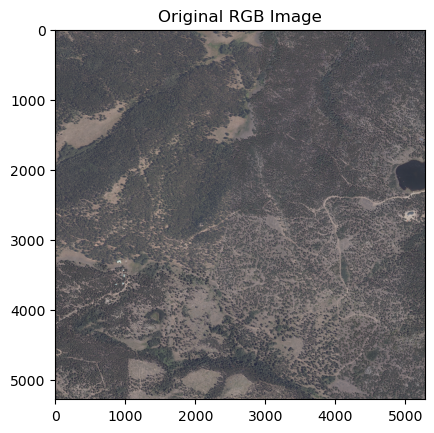

In [21]:
import rasterio
import matplotlib.pyplot as plt


# Open the TIFF file
with rasterio.open(test_tif) as src:
    red = src.read(1)
    green = src.read(2)
    blue = src.read(3)
    rgb = np.dstack((red, green, blue))
    plt.imshow(rgb)
    plt.title('Original RGB Image')
    plt.show()

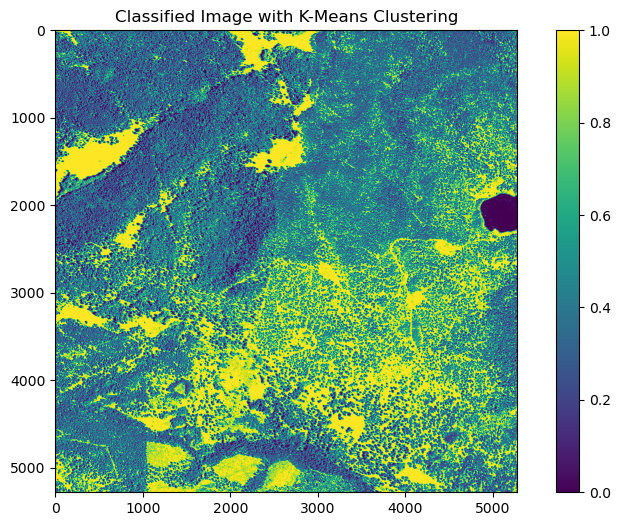

In [22]:
import rasterio
import numpy as np

# Load the GeoTIFF file
with rasterio.open(test_tif) as src:
    red = src.read(1)    # Red band
    green = src.read(2)  # Green band
    blue = src.read(3)   # Blue band
    nir = src.read(4)    # Near-Infrared band

# Combine the bands into a single array (assuming they are all the same size)
image_data = np.stack((red, green, blue, nir), axis=-1)

# Reshape the data for clustering
pixels = image_data.reshape((-1, 4))


from sklearn.cluster import KMeans

# Initialize k-means with the desired number of clusters
kmeans = KMeans(n_clusters=2, random_state=0)  # Change the number of clusters based on your needs
kmeans.fit(pixels)

# Get labels for each pixel
cluster_labels = kmeans.labels_

# Reshape labels back to the original image shape
clustered_image = cluster_labels.reshape(image_data.shape[:2])

import matplotlib.pyplot as plt

# Display the classified image
plt.figure(figsize=(10, 6))
plt.imshow(clustered_image, cmap='viridis')
plt.colorbar()
plt.title('Classified Image with K-Means Clustering')
plt.show()


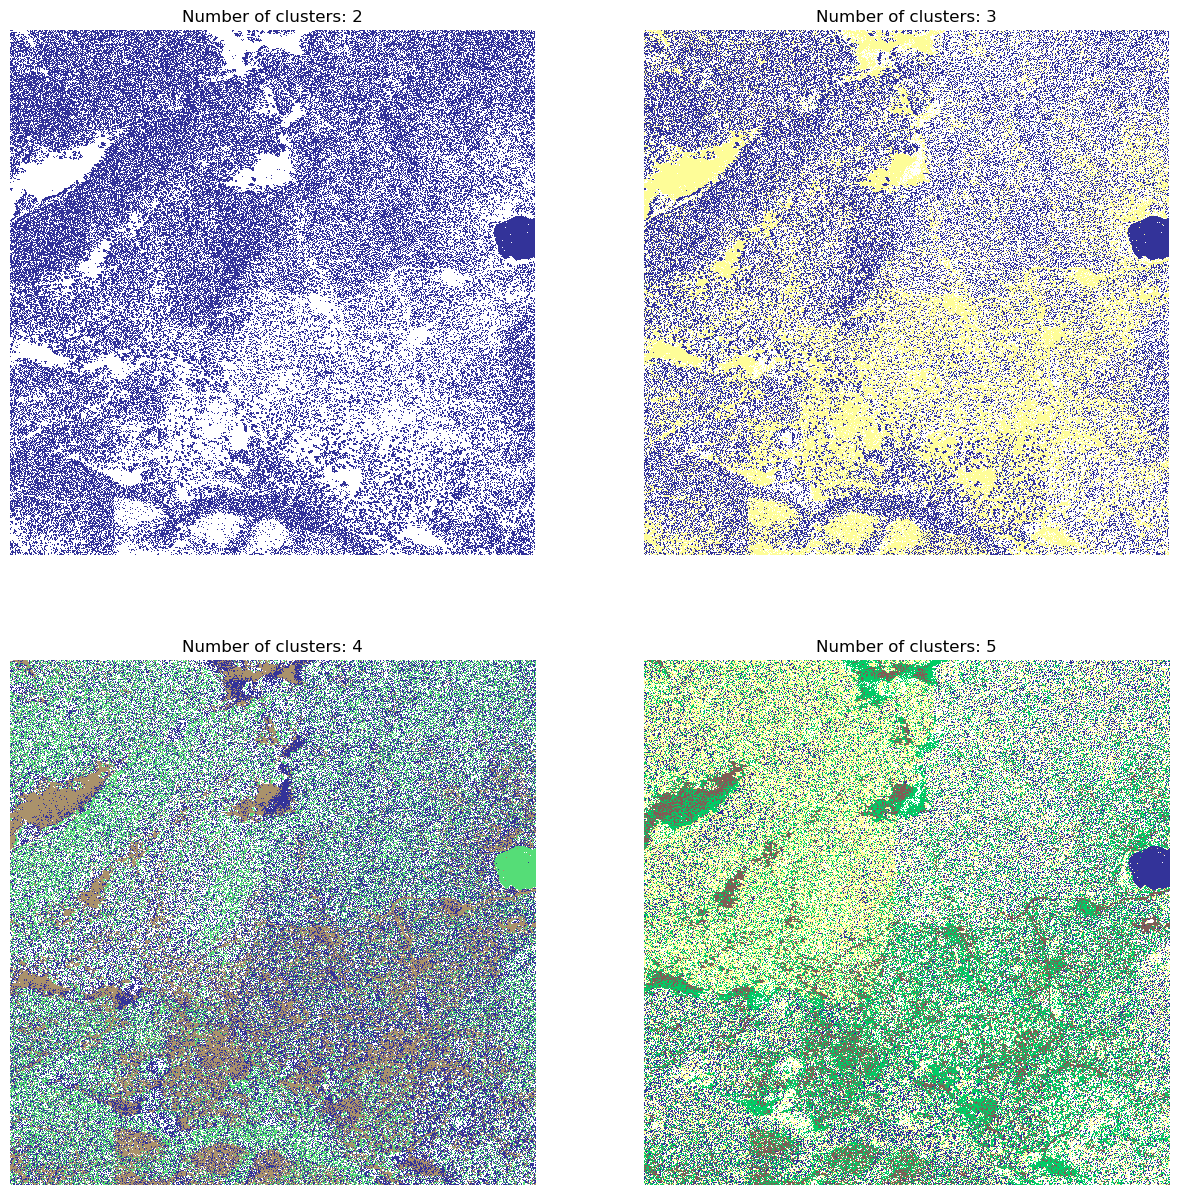

In [23]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Load the TIFF file
with rasterio.open(test_tif) as src:
    # Assuming bands 1 to 4 are RGB and NIR
    bands = [src.read(i) for i in range(1, 5)]
    image_data = np.dstack(bands)

# Prepare the data for clustering
pixels = image_data.reshape((-1, 4))  # Flatten the image data for clustering

# Dictionary to store predictions
predictions = {}

# Perform K-means clustering for 2 to n clusters
for k in range(2, 6): 
    kmeans = KMeans(n_clusters=k, random_state=0, n_init=10)
    kmeans.fit(pixels)
    labels = kmeans.labels_
    segmented_image = labels.reshape(image_data.shape[0], image_data.shape[1])
    predictions[k] = segmented_image

# Create a subplot grid and plot each clustering result
f, axes = plt.subplots(2, 2, figsize=(15, 15))  # Adjust subplot layout

for ax_i, (k, prediction) in enumerate(predictions.items()):
    if ax_i >= 6:
        continue
    ax = axes.flatten()[ax_i]
    im = ax.imshow(prediction, cmap="terrain", interpolation='none')
    ax.set_title("Number of clusters: " + str(k))
    ax.axis('off')  # Hide axis ticks

plt.show()

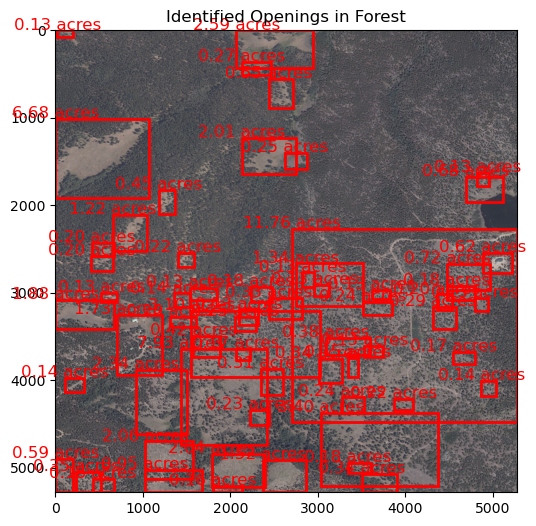

In [24]:
import numpy as np
import rasterio
from scipy.ndimage import binary_opening, generate_binary_structure
from skimage.measure import label, regionprops
import matplotlib.pyplot as plt

# Step 1: Load Image Data
with rasterio.open(test_tif) as src:
    bands = [src.read(i) for i in range(1, 5)]  # Read RGB and NIR bands
    image_data = np.dstack(bands)  # Stack bands along the third dimension

# Step 2: Preprocess Data
# Define a simple threshold to differentiate vegetation
# Adjust this threshold based on your data's characteristics
threshold = image_data.mean(axis=2) > 120

# Step 3: Morphological Operations
# Define a structural element for morphological operations
structuring_element = generate_binary_structure(2, 1)  # Two-dimensional, single connectivity
# Apply morphological opening to clean up small holes in the vegetation
open_areas = binary_opening(threshold, structure=structuring_element)

# Step 4: Label and Measure Connected Components
label_image = label(open_areas)
fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(image_data[:, :, 0:3], cmap='gray')  # Display RGB for visualization

# Pixel area to acres conversion based on image resolution
pixel_area_to_acres = (src.res[0] * src.res[1]) / 43560  # Convert resolution from meters/pixels to acres

# Measure and visualize each region
for region in regionprops(label_image):
    if (region.area * pixel_area_to_acres) >= (1/8):  # Filter regions smaller than 1/8 acre
        minr, minc, maxr, maxc = region.bbox
        rect = plt.Rectangle((minc, minr), maxc - minc, maxr - minr, fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)
        area_acres = region.area * pixel_area_to_acres
        ax.text(minc, minr - 10, f'{area_acres:.2f} acres', color='red', fontsize=12, ha='center')

plt.title('Identified Openings in Forest')
plt.show()
